In [446]:
for i in re.finditer(r'\b(?:Ene(?:ro)?|Feb(?:rero)?|Mar(?:zo)?|Abr(?:il)?|May(?:o)?|Jun(?:io)?|Jul(?:io)?|Ago(?:sto)?|Sep(?:tiembre)?|Set(?:iembre)?|Oct(?:ubre)?|(Nov|Dic)(?:iembre)?)\D?(\d{1,2}(st|nd|rd|th)?)?(([,.-/])\D?)?,?(\s)?((19[7-9]\d|20\d{2})|\d{2}\b)', 
          'november 9th, 2020 - july 31st, 2021', flags=re.IGNORECASE ):
    print(i)

In [442]:
for i in re.finditer(r'\b(?:Ene(?:ro)?|Feb(?:rero)?|Mar(?:zo)?|Abr(?:il)?|May(?:o)?|Jun(?:io)?|Jul(?:io)?|Ago(?:sto)?|Sep(?:tiembre)?|Set(?:iembre)?|Oct(?:ubre)?|(Nov|Dic)(?:iembre)?)', 
          'november 9th, 2020 - july 31st, 2021', flags=re.IGNORECASE ):
    print(i)

<re.Match object; span=(0, 3), match='nov'>
<re.Match object; span=(21, 24), match='jul'>


In [648]:
{k: k.lower().replace('_',' ') for k in df_roles.columns}

{'start_date': 'start date',
 'end_date': 'end date',
 'JOB_TITLE': 'job title',
 'count_axis': 'count axis',
 'duration': 'duration'}

In [447]:
a = {'a':1, 'b':2}

In [463]:
list(a.keys())[:1]

['a']

In [482]:
re.findall(r'((?:https?:)?\/\/(?:[\w]+\.)?linkedin\.com\/in\/(?P<permalink>[\w\-\_À-ÿ%]+)\/?)',
          "https://www.linkedin.com/in/jlgutierrezm/")

[('https://www.linkedin.com/in/jlgutierrezm/', 'jlgutierrezm')]

In [313]:
# Import libraries
import numpy as np
import pandas as pd
import sys
import os
import fitz
from unidecode import unidecode 
import re
import datetime
from spacy import displacy
import spacy
import unicodedata
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [7]:
sections_exps = {'experience':
                 [  
                     'PROFESSIONAL EXPERIENCE','WORK EXPERIENCE','EMPLOYMENT HISTORY','CAREER HISTORY',
                     'EXPERIENCIA PROFESIONAL',
                     'EXPERIENCE','EXPERIENCIA'
                 ],
                 'study':
                 [
                      'EDUCATION','EDUCACION','ESTUDIOS'
                 ],                 
                  'certificates':
                 [
                     'CERTIFICATES', 'CERTIFICATIONS', 'CERTIFICADOS','CERTIFICACIONES'
                 ],                 
                  'trainings':
                 [
                     'TRAININGS', 'COURSES', 'CAPACITACIONES'
                 ],                 
                  'skills':
                 [
                     'SKILLS','HABILIDADES'
                 ]
                 
                 
                }

In [2]:
## Functions for finding Sections headers
def sections_finder(_df0, sections_dict, sufix ='section'):
    results = pd.DataFrame()
    
    _df = _df0[(_df0['tag']!='p') | (_df0['is_bold'])][['text','font_size','tag','line_num','page_num','column']]
    for section,patts in sections_dict.items():
        for patt in patts:
            sections_found = _df[_df['text'].str.lower().str.contains(patt.lower())]
            if sections_found.shape[0]>0:
                sections_found['section']= section
                sections_found['patt'] = patt
                sections_found['patt_len'] = len(patt.split(' '))
                results = pd.concat([results,sections_found], axis=0, ignore_index=True)
    
    if results.shape[0]>0:
        results.sort_values(by=['section', 'font_size','tag','patt_len', 'page_num','line_num'], ascending=[False, False,True,False,True,True], inplace=True)
        results.drop_duplicates(['section'],inplace=True, keep='first')
        results.sort_values(by = 'line_num', inplace=True)
    return results

In [13]:
## Cleaning text
## Removing special characterst and replacing date related values
def clean_text(txt_content):
    ## Replace -Present variations in text
    txt_content = re.sub(r'[ -]\b(at)?present\b',' '+datetime.date.today().strftime(format = '%Y %m'), txt_content, flags=re.IGNORECASE)
    ## Replace -Present variations in text
    txt_content = re.sub(r'[ -][aA]ctual(idad)?',' '+datetime.date.today().strftime(format = '%Y %m'), txt_content)
    ## Replace , and -
    txt_content = re.sub(r'[,-]'," ", txt_content)
    ## Remove duplicated spaces
    txt_content = txt_content.replace(' de ', ' ')
    
    ## This could be skipped when a new code for processing Spanish CV's is developed
    months_dict = {
        'enero':'January',
        'febrero':'February',
        'marzo':'March',
        'abril':'April',
        'mayo':'May',
        'junio':'June',
        'julio':'July',
        'agosto':'August',
        'septiembre':'September',
        'setiembre':'September',
        'octubre':'October',
        'noviembre':'November',
        'diciembre':'December',
        
    }
    for month,val in months_dict.items():
        txt_content = txt_content.lower().replace(month,val, )
        
    ## Remove accents
    txt_content =''.join(c for c in unicodedata.normalize('NFD', txt_content)   if unicodedata.category(c) != 'Mn')
    return txt_content

In [274]:
## Find entities in text
def get_ents(text):
    nlp_text = nlp(text)
    entities = nlp_text.ents
    output = {}
    for label in nlp.get_pipe("entity_ruler").labels:
        output[label]= []
    for ent in entities:
            output[ent.label_].append(str(ent))
    return output
     

In [3]:
## Load NLP model (pre-trained)
nlp = spacy.load("en_core_web_md",disable=["ner"])

In [4]:
## Load skills json
skill_pattern_path = "../data/jz_skill_patterns.jsonl"

In [5]:
## Add entity ruler for skills.
## Added before NER to try to get this skills before any other entity predefined
ruler = nlp.add_pipe("entity_ruler", before='ner')
ruler.from_disk(skill_pattern_path)

In [6]:
## Add other customized pattern we wanna find
patterns = [{"label":'EMAIL',"pattern":[{"TEXT":{"REGEX":"([^@|\s]+@[^@]+\.[^@|\s]+)"}}]}]
ruler.add_patterns(patterns)

# Process CV

In [433]:
    "email":r'[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+',
    "phone" : r'[\+\(]?[1-9][0-9 .\-\(\)]{8,}[0-9]' ,
    'linkedIn': r'((?:https?:)?\/\/(?:[\w]+\.)?linkedin\.com\/in\/(?P<permalink>[\w\-\_À-ÿ%]+)\/?)'
    for k,v in patterns.items():
        val = re.findall(v, text)
        if len(val)>0:
            contact_info[k] = []
            contact_info[k].append(np.hstack(val)[0])

-1
0
1


In [532]:
"^\\+?\\d{1,4}?[-.\\s]?\\(?\\d{1,3}?\\)?[-.\\s]?\\d{1,4}[-.\\s]?\\d{1,4}[-.\\s]?\\d{1,9}$"[24]

'{'

In [618]:
txt ='a ndres e nrique p achon b ustos mobile: (+57) 301 698 2959 – (+57) 316 242 5908 phone: (+571) 547 9648 email: andrespachonb@hotmail.com , andres.pachon@gmail.com bogota, d.c, colombia s enior s oftware e ngineer – a rchitect / w eb and b ackend d eveloper professional profile competent and enthusiastic systems engineer with more than 17 years of professional experience in all phases of the software development life cycle, with a solid technical background in the design and development of functional architectures and enterprise software infrastructure and solutions for platforms and tools. web. solid knowledge and experience in the implementation of architectures, databases, data warehouses, data analytics structure and service-oriented information systems applying industry practices and standards taking into account ict resources, as well as the improvement, updating and maintenance of existing information systems. with the necessary skills to lead, evaluate and implement business management and technological transformation projects, contributing to the construction of safe, efficient and scalable solutions that contribute to the decision-making process of an organization. able to work on the creation of new guidelines according to capability maturity model integration (cmmi). analysis and preparation of reports from large volumes of data and with the ability to implement business intelligence projects, repositories and data warehouses. able to direct and support internal and / or external control systems, monitoring schemes, monitoring, control and management evaluation. able to direct and lead work teams with interdisciplinary performance, easy to learn, analyze and offer solutions that contribute to the achievement of business objectives. specialized in development and maintenance of web applications and in the creation and improvement of functional software architectures. core competencies: software architecture - software development - business requirements – process management -project management - monitoring and control - database management - web development - core development - process improvement - balance scorecard - audit - risk management - enterprise architecture – data analytics. software  skills • programming: c# and vb .net, java, java ee • web technologies: asp, asp mvc, share point , angularjs, html, jquery,  dnn dot net nuke, windows communication foundation (wcf), restful, soap • methodologies: rational unified process (rup), personal software process (psp), team software process(tsp), agile methods: extreme programming, scrum, unified modeling language (uml) • databases: microsoft sql server, oracle, mysql, postgresql.'

In [642]:
pattern = '(?:\\d{8}(?:\\d{2}(?:\\d{2})?)?|\\(\\+?\\d{2,3}\\)\\s?(?:\\d{4}[\\s*.-]?\\d{4}|\\d{3}[\\s*.-]?\\d{3}|\\d{2}([\\s*.-]?)\\d{2}\\1\\d{2}(?:\\1\\d{2})?))'
for match in re.finditer(pattern, txt):
    print(match, match.span())
    start, end = match.span()
    span = row['text'][start: end]

<re.Match object; span=(41, 54), match='(+57) 301 698'> (41, 54)
<re.Match object; span=(62, 75), match='(+57) 316 242'> (62, 75)
<re.Match object; span=(88, 102), match='(+571) 547 964'> (88, 102)


In [646]:
txt

'a ndres e nrique p achon b ustos mobile: (+57) 301 698 2959 – (+57) 316 242 5908 phone: (+571) 547 9648 email: andrespachonb@hotmail.com , andres.pachon@gmail.com bogota, d.c, colombia s enior s oftware e ngineer – a rchitect / w eb and b ackend d eveloper professional profile competent and enthusiastic systems engineer with more than 17 years of professional experience in all phases of the software development life cycle, with a solid technical background in the design and development of functional architectures and enterprise software infrastructure and solutions for platforms and tools. web. solid knowledge and experience in the implementation of architectures, databases, data warehouses, data analytics structure and service-oriented information systems applying industry practices and standards taking into account ict resources, as well as the improvement, updating and maintenance of existing information systems. with the necessary skills to lead, evaluate and implement business ma

In [645]:
len(span)

0

In [422]:
## Define folder with CVs
cv_folder = '../data/cv'
results ={'fname':[], 'n_columns':[]}

## Start processing each CV
for fname in [x for x in os.listdir(cv_folder) if x[0]!='.']:
    fname='Kabir Gramajo EN-CV.pdf' ## Example
    DIGITIZED_FILE = os.path.join(cv_folder, fname)

    ## Read pdf file with fitz
    with fitz.open(DIGITIZED_FILE) as doc:
        block_dict = {}
        page_num = 1
        line_num_test = 1

        for page in doc: # Iterate all pages in the document
            file_dict = page.get_text('dict') # Get the page dictionary 
            block = file_dict['blocks'] # Get the block information

            for a in block:   
                if a["type"] == 0:
                    for line in a['lines']:
                        for span in line['spans']:
                            span["page_num"] = page_num
                            span["line_num"] =  line_num_test

                    line_num_test += 1

                else :
                    a["page_num"] = page_num

            block_dict[page_num] = block # Store in block dictionary

            page_num += 1 # Increase the page value by 1

    rows = []
    
    ## Extract useful information for further processing steps
    for page_num, blocks in block_dict.items():
        for block in blocks:
            if block['type'] == 0:
                for line in block['lines']:
                    for span in line['spans']:
                        xmin, ymin, xmax, ymax = list(span['bbox'])
                        font_size = span['size']
                        color = span['color']
                        text = ''.join(c for c in unicodedata.normalize('NFD', span['text'])   if unicodedata.category(c) != 'Mn')#unidecode(span['text'])
                        span_font = span['font']
                        num_page = span["page_num"]
                        line_num = span['line_num']
                        block_num = block['number']
                        is_upper = False
                        is_bold = False 
                        if "bold" in span_font.lower():
                            is_bold = True 
                        if re.sub("[\(\[].*?[\)\]]", "", text).isupper():
                            is_upper = True
                        if text.replace(" ","") !=  "":
                            rows.append((xmin, ymin, xmax, ymax, line_num, block_num, num_page, text, is_upper, is_bold, span_font, font_size, color))

    
    ## Create a Dataframe with values 
    span_df = pd.DataFrame(rows, columns=['xmin','ymin','xmax','ymax', 'line_num', 'block_num', "page_num", 'text', 'is_upper','is_bold','span_font', 'font_size', 'color'])

    span_scores = []
    span_num_occur = {}
    special = '[(_:/,#%\=@)]'

    ## Get type of text
    ### In this section we will assign a class to each text
    ### 'p' will be the lowest type, commonly used for paragraph text
    ### Above 'p' will be 'h1', 'h2', etc.. usually headers of sections
    for index, span_row in span_df.iterrows():
        score = round(span_row.font_size)
        text = span_row.text

        if not re.search(special, text):
            if span_row.is_bold:
                score +=1 

            if span_row.is_upper:
                score +=1
        span_scores.append(score)
    values, counts = np.unique(span_scores, return_counts=True)

    values, counts = np.unique(span_scores, return_counts=True)
    style_dict = {}
    for value, count in zip(values, counts):
        style_dict[value] = count
    sorted(style_dict.items(), key=lambda x: x[1])

    p_size = max(style_dict, key=style_dict.get)
    idx = 0
    tag = {}

    for size in sorted(values, reverse = True):
        idx += 1
        if size == p_size:
            idx = 0
            tag[size] = 'p'
        if size > p_size:
            tag[size] = 'h{0}'.format(idx)
        if size < p_size:
            tag[size] = 's{0}'.format(idx)

    span_tags = [tag[score] for score in span_scores]

    span_df['tag'] = span_tags

    break
    ## Data Handling

    ### Columns Pre bucketing 
    #As can be seen in the dataframe, there is text from the same line separated by rows. This for/while loop joins them together with its correct bbox values per variable.
    ## Merge text from same line
    deletion = []

    for index, line in enumerate(span_df.line_num):

        try :
            contador = 1
            while span_df.loc[index, 'line_num'] == span_df.loc[(index + contador), 'line_num']: 
                span_df.loc[index, 'text'] = span_df.loc[index,'text'].strip() + " " + span_df.loc[index+contador, 'text'].strip()
                deletion.append(index+contador)
                contador += 1

            if contador > 1:
                span_df.loc[index, 'xmin'] = [min(span_df.loc[index:index+contador - 1,'xmin'])]
                span_df.loc[index, 'ymin'] = [min(span_df.loc[index:index+contador - 1,'ymin'])]
                span_df.loc[index, 'xmax'] = [max(span_df.loc[index:index+contador - 1,'xmax'])]
                span_df.loc[index, 'ymax'] = [max(span_df.loc[index:index+contador - 1,'ymax'])]

        except KeyError as error :
            continue

    span_df.drop(deletion, axis = 0, inplace= True) ## Drop lines merged
    span_df.reset_index(drop = True, inplace = True)
    ## solve multiple space issue
    ### Some text is read badly from pdf because of special fonts
    ### We could find date texts like 'J AN U ARY' that won't help us to recognize dates inside the text.
    ### For that reason, we will look for those patterns to remove additional spaces
    span_df['collapse'] = span_df['text'].str.replace(r' +',' ', regex=True).str.contains('[A-Z0-9]{1,2} [A-Z0-9]{1,2} [A-Z0-9]{1,2} [A-Z0-9]{1,2}', regex=True)
    span_df.loc[span_df['collapse'],'text']=span_df[span_df['collapse']]['text'].str.replace('  ','__').str.replace(' ','').str.replace('__',' ') 
    
    ## Identify columns patterns in first page
    ## Assume first page columns pattern is replicated over pages
    page_one = span_df[span_df['page_num']==1] ## Focus on page 1
    page_one_width = page_one['xmax'].max() -  page_one['xmin'].min() # Get maximum range 
    
    ## Get potential rectangle occupied by main column
    main_col_candidates = page_one.groupby(['xmin']).agg({'line_num':'count' , 'xmax':'max','ymin':'min' }).reset_index()
    main_col_candidates['width'] = main_col_candidates['xmax'] - main_col_candidates['xmin']
    main_col = main_col_candidates[main_col_candidates['width']>page_one_width/2].sort_values(by = 'line_num', ascending = False).head(1)
    
    ## Find coordinates occupied
    main_col_x_min = main_col['xmin'].values[0]
    main_col_x_max = main_col['xmax'].values[0]

    main_col_y_min = main_col['ymin'].values[0]
    
    sep_thresh=7 # Threshold for no-overlaping between main and secondary column
    
    ## Find lines that do not overlap main column with threshold
    page_one['flg_other_column']=((page_one['xmax']+sep_thresh<main_col_x_min )| (page_one['xmin']>main_col_x_max+sep_thresh ))*1
    page_one['width'] = page_one['xmax']  - page_one['xmin']
    sec_col = page_one[(page_one['flg_other_column']==1 ) & (page_one['ymax']>=main_col_y_min)]
    
    ## Get the maximum xaxis coordinate of secondary column
    sec_col = sec_col[sec_col['width']==sec_col['width'].max()] 
    sec_col_x_min = sec_col['xmin'].min()
    sec_col_x_max = sec_col['xmax'].max()
    
    ## Recalculate coordinates of secondary column
    if sec_col_x_min<(page_one['xmax'].max() +  page_one['xmin'].min())/2:
        sec_col_x_min=0
    else:
        sec_col_x_max = page_one['xmax'].max()
        
        
    span_df['column']='main'
    
    #Assign 'secondary'column tag if found
    lines_other_column = page_one['flg_other_column'].sum() ## count total 'secondary' lines
    if lines_other_column>=5: # Enough to conclude there are 2 columns
        span_df.loc[((span_df['xmin']>=sec_col_x_min - sep_thresh) & (span_df['xmax']<=sec_col_x_max+sep_thresh) ),'column']='secondary'
        
    print('the file {} has {} columns in the document'.format(fname,span_df['column'].nunique() ))
    results['fname'].append(fname)
    results['n_columns'].append(span_df['column'].nunique())
    
    ## Sort values 
    span_df.sort_values(by=['column','page_num','ymin'], inplace=True)
    
    break

In [430]:
span_df.loc[28:38]

,xmin,ymin,xmax,ymax,line_num,block_num,page_num,text,is_upper,is_bold,span_font,font_size,color,tag
28,23.280001,131.260925,84.595932,146.518738,36,36,1,Education,False,True,Roboto-Bold,13.02,3815480,h2
29,23.280001,148.845016,251.920197,159.825012,36,36,1,2020 – Computer science and systems engineering,False,True,Calibri-BoldItalic,10.98,0,h4
30,23.280001,161.985001,87.408745,172.005005,36,36,1,Pensum Closed,False,False,Calibri,10.02,0,p
31,23.279999,174.229446,189.702927,184.249451,36,36,1,Mariano Galvez of Guatemala University,False,False,Calibri,10.02,0,p
32,23.280001,200.144516,194.777100,211.124512,36,36,1,2006 – Bachelor of science and letters,False,True,Calibri-BoldItalic,10.98,0,h4
33,23.280001,213.284988,147.339371,223.304993,36,36,1,Liceo Javier school Guatemala,False,False,Calibri,10.02,0,p
34,23.280001,237.220886,124.738815,252.478699,36,36,1,Work Experience,False,True,Roboto-Bold,13.02,3815480,h2
35,23.280001,254.804977,121.529854,265.784973,36,36,1,Senior Data Engineer,False,True,Calibri-Bold,10.98,0,h4
36,23.290970,268.244507,250.951096,279.224487,36,36,1,BairesDev (International Contractor). 2020 - T...,False,False,Calibri-Italic,10.98,0,h5
37,23.290970,287.679108,65.553802,298.659088,37,37,1,Pinterest,False,False,Calibri-Italic,10.98,0,h5


In [414]:
df_sections['text'
].values

array(['Education 2020 – Computer science and systems engineering Pensum Closed Mariano Galvez of Guatemala University 2006 – Bachelor of science and letters Liceo Javier school Guatemala Work Experience Senior Data Engineer BairesDev (International Contractor). 2020 - Today',
       'Education 2020 – Computer science and systems engineering Pensum Closed Mariano Galvez of Guatemala University 2006 – Bachelor of science and letters Liceo Javier school Guatemala Work Experience Senior Data Engineer BairesDev (International Contractor). 2020 - Today'],
      dtype=object)

In [416]:
df_sections

,text,font_size,tag,line_num,page_num,column,section,patt,patt_len
2,Education 2020 – Computer science and systems ...,13.02,h2,36,1,main,study,EDUCATION,1
0,Education 2020 – Computer science and systems ...,13.02,h2,36,1,main,experience,WORK EXPERIENCE,2


In [419]:
span_df

,xmin,ymin,xmax,ymax,line_num,block_num,page_num,text,is_upper,is_bold,span_font,font_size,color,tag,collapse,column
13,67.980003,19.471313,373.512756,45.276001,43,44,1,Kabir Estuardo Gramajo Lopez,False,True,Roboto-Bold,22.02,0,h1,False,main
12,24.110001,58.125015,418.004974,124.299065,42,43,1,"My knowledge, professional experiences and per...",False,False,Calibri,10.02,0,p,False,main
6,23.279999,131.260925,251.920197,279.224487,36,36,1,Education 2020 – Computer science and systems ...,False,True,Roboto-Bold,13.02,3815480,h2,False,main
7,23.290970,287.679108,65.553802,298.659088,37,37,1,Pinterest,False,False,Calibri-Italic,10.98,0,h5,False,main
8,23.280001,305.332764,421.521606,556.724976,38,38,1, Leadership and development of Direct Acyclic...,False,False,Wingdings-Regular,10.02,0,p,False,main
9,30.359985,563.452759,419.333160,771.437256,39,39,1, Administrator and developer of AWS Redshift ...,False,False,Wingdings-Regular,10.02,0,p,False,main
0,90.000000,685.020020,209.412857,697.020020,25,24,1,48 calle 29-08 zona 12,False,False,Calibri,12.00,16777215,h4,False,main
16,22.200001,20.504990,168.982300,31.484989,48,4,2,Junior Data Engineer Developer,False,True,Calibri-Bold,10.98,0,h4,False,main
17,22.200001,33.944992,252.198883,44.924992,49,5,2,"Supreme Court of Justice, Guatemala. 2014 – 2...",False,False,Calibri-Italic,10.98,0,h5,False,main
18,32.580002,51.126194,37.188812,63.401672,50,6,2,• ETL processes developer using Microsoft Data...,False,False,SymbolMT,10.02,0,p,False,main


In [411]:
## Identify sections
df_sections = sections_finder(span_df, sections_exps)
if df_sections.shape[0]>0:
     span_df  = (
         span_df
         .merge(
             df_sections[['line_num','page_num','section']],
             how = 'left',
             on = ['line_num','page_num'], 
             validate = 'many_to_one')
     )
## Fill sections column
span_df['section']=span_df.groupby(['column'])['section'].ffill()

MergeError: Merge keys are not unique in right dataset; not a many-to-one merge

# Process Work history

In [268]:
## Keep only work experience section
df_exp = span_df[span_df['section']=='experience'].sort_values(by=['page_num','ymin'])
df_exp['text'] = df_exp['text'].map(clean_text)

In [396]:
# Identify different dates format in the text

## Define patterns 
exps = [
    r'\b(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|(Nov|Dec)(?:ember)?)\D?(\d{1,2}(st|nd|rd|th)?)?(([,.-/])\D?)?,?(\s)?((19[7-9]\d|20\d{2})|\d{2})',
    r'\b(?:Ene(?:ro)?|Feb(?:rero)?|Mar(?:zo)?|Abr(?:il)?|May(?:o)?|Jun(?:io)?|Jul(?:io)?|Ago(?:sto)?|Sep(?:tiembre)?|Set(?:iembre)?|Oct(?:ubre)?|(Nov|Dic)(?:iembre)?)\D?(\d{1,2}(st|nd|rd|th)?)?(([,.-/])\D?)?,?(\s)?((19[7-9]\d|20\d{2})|\d{2})',
    
    r'\b(\d{2} )?(\d{2} )(20\d{2})\b(?!\d)',
    r'\b(\d{2}\/)?(\d{2}\/)(20\d{2})\b(?!\d)',
    r'\b(\d{2}\.)?(\d{2}\.)(20\d{2})\b(?!\d)',
    r'\b(\d{2})?(\d{2})(20\d{2})\b(?!\d)',
    
    r'\b(20\d{2} )(\d{2})( \d{2})?\b',
    r'\b(20\d{2}\/)(\d{2})(\/\d{2})?\b',
    r'\b(20\d{2}\.)(\d{2})(\.\d{2})\b'
]
## Collect useful data from date text
dates_dict = {
    'span_start':[],
    'span_end': [], 
    'span_text':[], 
    'date_formated':[],
    'idx':[]
}

## process each pattern
for idx,row in df_exp.iterrows():
    for reg in exps:
        for match in re.finditer(reg, row['text'], flags=re.IGNORECASE): ## if pattern match
            print(match)
            start, end = match.span()
            span = row['text'][start: end]
            # This is a Span object or None if match doesn't map to valid token sequence
            if span is not None:
                bag_dates.append([span,start,end,pd.to_datetime(span)]) ## add matched date string
                ## Save data from date matched
                #print("Found match:", span)
                dates_dict['span_start'].append(start)
                dates_dict['span_end'].append(end)
                dates_dict['span_text'].append(span)
                dates_dict['date_formated'].append(pd.to_datetime(span))
                dates_dict['idx'].append(idx)

<re.Match object; span=(0, 10), match='march 2022'>
<re.Match object; span=(12, 19), match='2023 03'>
<re.Match object; span=(0, 8), match='june2021'>
<re.Match object; span=(0, 8), match='june2021'>
<re.Match object; span=(10, 17), match='2023 03'>
<re.Match object; span=(0, 10), match='august2019'>
<re.Match object; span=(12, 21), match='june 2021'>
<re.Match object; span=(12, 21), match='june 2021'>
<re.Match object; span=(0, 8), match='may 2010'>
<re.Match object; span=(11, 22), match='august 2019'>
<re.Match object; span=(0, 8), match='may 2010'>


In [270]:
## Create a dataframe from dates found
dates_df = (
    pd.DataFrame(dates_dict)
    .sort_values(by ='span_start', ascending=True)
    .drop_duplicates(['span_start','span_end','idx']))

In [271]:
dates_df

,span_start,span_end,span_text,date_formated,idx
0,0,10,march 2022,2022-03-01,6
2,0,8,june2021,2021-06-01,12
5,0,10,august2019,2019-08-01,19
8,0,8,may 2010,2010-05-01,27
4,10,17,2023 03,2023-03-01,12
9,11,22,august 2019,2019-08-01,27
1,12,19,2023 03,2023-03-01,6
6,12,21,june 2021,2021-06-01,19


In [272]:
## Match dates pairs found
dates_df = (
    pd.DataFrame(dates_dict)
    .sort_values(by ='span_start', ascending=True)
    .drop_duplicates(['span_start','span_end','idx']))

dates_df = dates_df.groupby('idx').agg({'span_text':'count', 'date_formated':['min','max']})
dates_df.columns = ['n_dates', 'start_date', 'end_date']
dates_df = dates_df[dates_df['n_dates']==2]
dates_df.index.name = None
dates_df

,n_dates,start_date,end_date
6,2,2022-03-01,2023-03-01
12,2,2021-06-01,2023-03-01
19,2,2019-08-01,2021-06-01
27,2,2010-05-01,2019-08-01


In [273]:
## Return dates to their original lines
df_exp = df_exp.merge(dates_df, how = 'left', validate='many_to_one', left_index = True, right_index = True )

In [275]:
## Get entities from text
df_exp['entities'] = df_exp['text'].map(get_ents)

In [276]:
## Get useful columns from entities
for label in nlp.get_pipe("entity_ruler").labels:
    df_exp[label] = df_exp['entities'].map(lambda x: x[label])
    df_exp[label + '_FOUND'] = df_exp['entities'].map(lambda x: len(x[label])>0)

In [277]:
# Assign Job Title if found

## Get first job title found
df_exp.loc[df_exp['JOB_TITLE_FOUND'], 'JOB_TITLE'] = df_exp[df_exp['JOB_TITLE_FOUND']]['JOB_TITLE'].map(lambda x: x[0])
df_exp.loc[~df_exp['JOB_TITLE_FOUND'], 'JOB_TITLE'] = None

## Assign start and end date when job title found
### Look one line before
df_exp.loc[(df_exp['JOB_TITLE'].notnull()) & (df_exp['n_dates'].shift(1).notnull()) & (df_exp['JOB_TITLE'].shift(1).isnull()) , 'start_date']= df_exp['start_date'].shift(1)
df_exp.loc[(df_exp['JOB_TITLE'].notnull()) & (df_exp['n_dates'].shift(1).notnull()) & (df_exp['JOB_TITLE'].shift(1).isnull()), 'end_date']= df_exp['end_date'].shift(1)
## Look one line after
df_exp.loc[(df_exp['JOB_TITLE'].notnull()) & (df_exp['start_date'].isnull()) & (df_exp['n_dates'].shift(-1).notnull()) & (df_exp['JOB_TITLE'].shift(-1).isnull()) , 'start_date']= df_exp['start_date'].shift(-1)
df_exp.loc[(df_exp['JOB_TITLE'].notnull()) & (df_exp['end_date'].isnull()) & (df_exp['n_dates'].shift(-1).notnull()) & (df_exp['JOB_TITLE'].shift(-1).isnull()), 'end_date']= df_exp['end_date'].shift(-1)

## Remove job titles not close to dates
df_exp.loc[(df_exp['JOB_TITLE'].notnull()) & (df_exp['start_date'].isnull()), 'JOB_TITLE'] = np.NaN

## Fill start and end dates, asumming date always are before the description of the experience 
df_exp['start_date'] = df_exp['start_date'].ffill()
df_exp['end_date'] = df_exp['end_date'].ffill()

,xmin,ymin,xmax,ymax,line_num,block_num,page_num,text,is_upper,is_bold,...,n_dates,start_date,end_date,entities,EMAIL,EMAIL_FOUND,JOB_TITLE,JOB_TITLE_FOUND,SKILL,SKILL_FOUND
5,65.639999,245.288864,231.419601,255.197052,8,11,1,data engineer bairesdev united states,False,False,...,NaN,NaT,NaT,"{'EMAIL': [], 'JOB_TITLE': ['data engineer'], ...",[],False,data engineer,True,[],False
24,76.080002,526.871094,339.467560,536.216309,27,30,1,● design dashboards and reports using data vis...,False,False,...,NaN,NaT,NaT,"{'EMAIL': [], 'JOB_TITLE': [], 'SKILL': ['data...",[],False,None,False,[data visualization],True
17,76.080002,413.591064,305.889130,422.936279,20,23,1,● design dashboards or reports using tableau o...,False,False,...,NaN,NaT,NaT,"{'EMAIL': [], 'JOB_TITLE': [], 'SKILL': ['tabl...",[],False,None,False,"[tableau, superset]",True


In [280]:
## Summary of Skills:
dict_skills = {
    'skill':[],
    'start_date': [],
    'end_date':[]
}
df_skills = df_exp[df_exp['SKILL_FOUND']][['SKILL','start_date', 'end_date']]
for _,row in df_skills.iterrows():
    for skill in row['SKILL']:
        dict_skills['skill'].append(skill)
        dict_skills['start_date'].append(row['start_date'])
        dict_skills['end_date'].append(row['end_date'])
df_skills = pd.DataFrame(dict_skills).drop_duplicates()
df_skills

,skill,start_date,end_date
0,python,2022-03-01,2023-03-01
1,business intelligence,2021-06-01,2023-03-01
2,data warehouse,2021-06-01,2023-03-01
3,database,2021-06-01,2023-03-01
4,tableau,2021-06-01,2023-03-01
5,superset,2021-06-01,2023-03-01
8,data warehouse,2019-08-01,2021-06-01
9,postgresql,2019-08-01,2021-06-01
10,database,2019-08-01,2021-06-01
11,data modeling,2019-08-01,2021-06-01


In [281]:
# Remove traslaping dates
df_skills_clean = pd.DataFrame()
for _,i in df_skills.iterrows():
    df_to_add = pd.DataFrame(pd.date_range(i['start_date'],i['end_date'] ,freq="MS" ,inclusive='both' ))
    df_to_add['skill'] = i['skill']
    df_skills_clean = pd.concat([df_skills_clean,df_to_add], axis = 0, ignore_index=True)
    
df_skills_clean.drop_duplicates(inplace=True)
df_skills_clean = df_skills_clean.groupby(['skill']).agg({0:['count','min', 'max']}).reset_index()
df_skills_clean.columns = ['skill','total_months','min_date', 'max_date']
df_skills_clean

,skill,total_months,min_date,max_date
0,business intelligence,134,2010-05-01,2023-03-01
1,data mining,112,2010-05-01,2019-08-01
2,data modeling,23,2019-08-01,2021-06-01
3,data visualization,23,2019-08-01,2021-06-01
4,data warehouse,155,2010-05-01,2023-03-01
5,database,44,2019-08-01,2023-03-01
6,oracle,112,2010-05-01,2019-08-01
7,postgresql,23,2019-08-01,2021-06-01
8,python,13,2022-03-01,2023-03-01
9,superset,22,2021-06-01,2023-03-01


In [373]:
df_roles = df_exp[(df_exp['start_date'].notnull()) & (df_exp['end_date'].notnull()) ][['start_date','end_date', 'JOB_TITLE']].drop_duplicates()
df_roles['count_axis'] = df_roles.count(axis=1)
df_roles.sort_values(by = ['start_date','end_date','count_axis' ], ascending = False)
df_roles.drop_duplicates(['start_date','end_date'], keep = 'first', inplace= True)
df_roles['JOB_TITLE'] =df_roles['JOB_TITLE'].fillna('Unknown')
df_roles['duration'] = (df_roles['end_date'] - df_roles['start_date']).dt.days // 30


df_roles

,start_date,end_date,JOB_TITLE,count_axis,duration
5,2022-03-01,2023-03-01,data engineer,3,12
11,2021-06-01,2023-03-01,data engineer,3,21
19,2019-08-01,2021-06-01,Unknown,2,22
26,2010-05-01,2019-08-01,coordinator,3,112


In [374]:
# Calculate total experience
total_months = pd.DataFrame()
for _,i in df_roles.iterrows():
    total_months = pd.concat([
        total_months,
        pd.DataFrame(pd.date_range(i['start_date'] - pd.Timedelta(days = i['start_date'].day-1),i['end_date'] ,freq="MS" ,inclusive='both' ))
    ], axis = 0, ignore_index=True)
total_months.drop_duplicates(inplace=True)
print('First and Last months of experience:', total_months[0].min(), ' - ', total_months[0].max())
print('Total months of experience: {}'.format(total_months.shape[0]))

First and Last months of experience: 2010-05-01 00:00:00  -  2023-03-01 00:00:00
Total months of experience: 155


In [397]:
import sys
print(sys.executable)

/Users/anthony.ruiz/env/bin/python3


________________

# OPTIONAL

In [377]:
df_sections.to_string()

'               text  font_size tag  line_num  page_num     column     section             patt  patt_len\n0  Work Experience   12.159975  h2         7         1       main  experience  WORK EXPERIENCE         2\n4           Skills   10.358550  h3        47         1  secondary      skills           SKILLS         1\n2        Education   12.159975  h2        64         2       main       study        EDUCATION         1\n3          Courses   12.159975  h2        70         2       main   trainings          COURSES         1'

In [387]:
[['lightgray']*c] + [['none']*c]*(d-1)

[['lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray'],
 ['none', 'none', 'none', 'none', 'none'],
 ['none', 'none', 'none', 'none', 'none'],
 ['none', 'none', 'none', 'none', 'none']]

In [392]:
[['lightgray']*c] + [['none']*c]*(d)

[['lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray'],
 ['none', 'none', 'none', 'none', 'none'],
 ['none', 'none', 'none', 'none', 'none'],
 ['none', 'none', 'none', 'none', 'none'],
 ['none', 'none', 'none', 'none', 'none']]

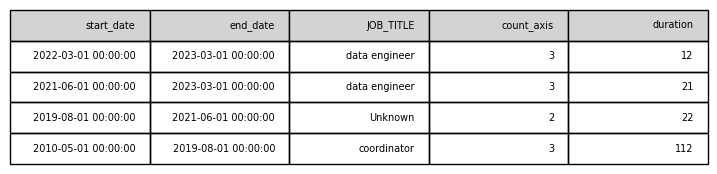

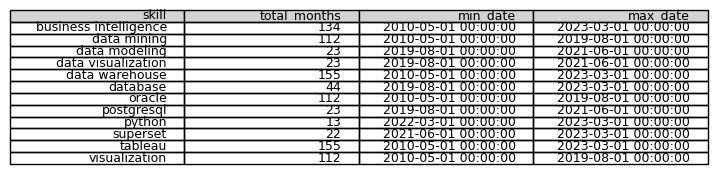

In [395]:
## Export results into PDF
## We can export a customized PDF with results
#path = "PyMuPDF_test.pdf"

with fitz.open() as new_pdf:
    fig = plt.figure(figsize=(9,2))
    ax=plt.subplot(111)
    ax.axis('off')
    c = df_roles.shape[1]
    d = df_roles.shape[0]
    ax.table(cellText=np.vstack([df_roles.columns, df_roles.values]), cellColours=[['lightgray']*c] + [['none']*c]*(d), bbox=[0,0,1,1])
    fig.savefig('roles.png' )
    
    new_pdf.insert_page(0)
    for page in new_pdf:
        rect = fitz.Rect(20, 40, 600, 600) 
        page.insert_text(fitz.Point(20, 20), fname, fontsize=11)
        page.insert_text(fitz.Point(20, 40), 'First and Last months of experience:' +  str(total_months[0].min()) +  ' - ' +  str(total_months[0].max()), fontsize=12)
        page.insert_text(fitz.Point(20, 80), 'Sections found:'+ df_sections.to_string(), fontsize=12)
        page.insert_image( filename='roles.png', rect = rect )
        
        
        fig = plt.figure(figsize=(9,2))
        ax=plt.subplot(111)
        ax.axis('off')
        c = df_skills_clean.shape[1]
        d = df_skills_clean.shape[0]
        ax.table(cellText=np.vstack([df_skills_clean.columns, df_skills_clean.values]), cellColours=[['lightgray']*c] + [['none']*c]*(d), bbox=[0,0,1,1])
        fig.savefig('skills.png' )
        rect = fitz.Rect(20, 800, 600, 1600) 
        page.insert_image( filename='skills.png', rect = rect )
        os.remove('skills.png')
        os.remove('roles.png')
        new_pdf.save('example.pdf')

In [409]:
with open('test.html', mode ='r') as f:
    filedata = f.read()
    
filedata = filedata.replace('[SKILLS]', df_skills.to_html(index=False, classes='mystyle'))

    
with open('test.html', mode ='w') as f:
    f.write(filedata)                                           

In [384]:
[['lightgray']*c] + [['none']*c]*(d-1)

[['lightgray', 'lightgray', 'lightgray', 'lightgray'],
 ['none', 'none', 'none', 'none'],
 ['none', 'none', 'none', 'none'],
 ['none', 'none', 'none', 'none']]

In [378]:
df_skills_clean

,skill,total_months,min_date,max_date
0,business intelligence,134,2010-05-01,2023-03-01
1,data mining,112,2010-05-01,2019-08-01
2,data modeling,23,2019-08-01,2021-06-01
3,data visualization,23,2019-08-01,2021-06-01
4,data warehouse,155,2010-05-01,2023-03-01
5,database,44,2019-08-01,2023-03-01
6,oracle,112,2010-05-01,2019-08-01
7,postgresql,23,2019-08-01,2021-06-01
8,python,13,2022-03-01,2023-03-01
9,superset,22,2021-06-01,2023-03-01
